.. index:: Equations; Darcy flow

.. index:: Methods; hp adaptive Discontinuous Galerkin

# Problem Description
This example considers two-phase porous-media flow.
In all that follows, we assume that the flow is immiscible and
incompressible with no mass transfer between phases.
A detailed description of the mathematical model and parameters
can be found <cite data-cite="TwoPhaseFlow"></cite>.
import sys

In [1]:
try:
    import dune.femdg
except ImportError:
    print("This example needs 'dune.femdg' - skipping")
    sys.exit(0)

from matplotlib import pyplot

import sys
import numpy
from ufl import *
from dune.ufl import Space, Constant
import dune.ufl

import dune.fem as fem
from dune.alugrid import aluCubeGrid
from dune.fem.view import adaptiveLeafGridView
from dune.generator import algorithm
from dune.common import FieldVector
from dune.grid import cartesianDomain, Marker
from dune.fem.function import levelFunction, gridFunction
from dune.fem import integrate
from dune.fem.scheme import galerkin
from dune.fem.operator import galerkin as galerkinOp
from dune.fem.space import dglegendrehp, product, finiteVolume
from dune.fem import GridMarker, SpaceMarker

from dune.plotting import plotPointData as plot

from dune.femdg import createOrderRedcution, createLimiter

fem.threading.use = 4

Some parameters

In [2]:
maxLevel  = 3
maxOrder  = 3
dt        = 5.
# shorter run time for nightly testing
endTime   = 200. if len(sys.argv) > 1 and sys.argv[1] == 'testing' else 800.
coupled   = False
# coupled   = True
tolerance = 3e-2
penalty   = 5 * (maxOrder * ( maxOrder + 1 ))
newtonParameters = {"nonlinear.tolerance": tolerance,
                    "nonlinear.verbose": "false",
                    "linear.verbose": "false",
                    "linear.tolerance": 1e-8,
                    "linear.reduction": 1e-8}

# Defining the model
using a Brooks Corey pressure law

In [3]:
def brooksCorey(P,s_n):
    s_w = 1-s_n
    s_we = (s_w-P.s_wr)/(1.-P.s_wr-P.s_nr)
    s_ne = (s_n-P.s_nr)/(1.-P.s_wr-P.s_nr)
    if P.useCutOff:
        cutOff = lambda a: min_value(max_value(a,0.00001),0.99999)
        s_we = cutOff(s_we)
        s_ne = cutOff(s_ne)
    kr_w = s_we**((2.+3.*P.theta)/P.theta)
    kr_n = s_ne**2*(1.-s_we**((2.+P.theta)/P.theta))
    p_c  = P.pd*s_we**(-1./P.theta)
    dp_c = P.pd * (-1./P.theta) * s_we**(-1./P.theta-1.) * (-1./(1.-P.s_wr-P.s_nr))
    l_n  = kr_n / P.mu_n
    l_w  = kr_w / P.mu_w
    return p_c,dp_c,l_n,l_w

Constants and domain description for anisotropic lens test

In [4]:
class AnisotropicLens:
    dimWorld = 2
    domain   = cartesianDomain([0,0.39],[0.9,0.65],[15,4])
    x        = SpatialCoordinate(dune.ufl.Space(2))

    g     = [0,]*dimWorld ; g[dimWorld-1] = -9.810 # [m/s^2]
    g     = as_vector(g)
    r_w   = 1000.  # [Kg/m^3]
    mu_w  = 1.e-3  # [Kg/m s]
    r_n   = 1460.  # [Kg/m^3]
    mu_n  = 9.e-4  # [Kg/m s]

    lens = lambda x,a,b: (a-b)* \
            (conditional(abs(x[1]-0.49)<0.03,1.,0.)* \
             conditional(abs(x[0]-0.45)<0.11,1.,0.)) + b

    p_c = brooksCorey

    Kdiag = lens(x, 6.64*1e-14, 1e-10) # [m^2]
    Koff  = lens(x, 0,-5e-11)          # [m^2]
    K     = as_matrix( [[Kdiag,Koff],[Koff,Kdiag]] )

    Phi   = lens(x, 0.39, 0.40)             # [-]
    s_wr  = lens(x, 0.10, 0.12)             # [-]
    s_nr  = lens(x, 0.00, 0.00)             # [-]
    theta = lens(x, 2.00, 2.70)             # [-]
    pd    = lens(x, 5000., 755.)            # [Pa]

    #### initial conditions
    p_w0 = (0.65-x[1])*9810.       # hydrostatic pressure
    s_n0 = 0                       # fully saturated
    # boundary conditions
    inflow = conditional(abs(x[0]-0.45)<0.06,1.,0.)* conditional(abs(x[1]-0.65)<1e-8,1.,0.)
    J_n  = -5.137*1e-5
    J_w  = 1e-20
    dirichlet = conditional(abs(x[0])<1e-8,1.,0.) + conditional(abs(x[0]-0.9)<1e-8,1.,0.)
    p_wD = p_w0
    s_nD = s_n0

    q_n  = 0
    q_w  = 0

    useCutOff = False

P = AnisotropicLens()

Setup grid, discrete spaces and functions

In [5]:
grid = adaptiveLeafGridView( aluCubeGrid( P.domain, dimgrid=2) )

if coupled:
    spc          = dglegendrehp(grid, dimRange=2, order=maxOrder)
else:
    spc1         = dglegendrehp(grid, dimRange=1, order=maxOrder)
    spc          = product( spc1,spc1, components=["p","s"] )

solution     = spc.function(name="solution")
solution_old = spc.function(name="solution_old")
sol_pm1      = spc.function(name="sol_pm1")
intermediate = spc.function(name="iterate")
persistentDF = [solution,solution_old,intermediate]

fvspc        = finiteVolume( grid, dimRange=1)
estimate     = fvspc.function(name="estimate")
estimate_pm1 = fvspc.function(name="estimate-pm1")

In [6]:
uflSpace = Space((P.dimWorld,P.dimWorld),2)
u        = TrialFunction(uflSpace)
v        = TestFunction(uflSpace)
x        = SpatialCoordinate(uflSpace)
tau      = Constant(dt, name="timeStep")
beta     = Constant(penalty, name="penalty")

p_w  = u[0]
s_n  = u[1]

p_c,dp_c,l_n,l_w = P.p_c(s_n=intermediate[1])

Bulk terms

In [7]:
dBulk_p  = P.K*( (l_n+l_w)*grad(p_w) + l_n*dp_c*grad(s_n) )
dBulk_p += -P.K*( (P.r_n*l_n+P.r_w*l_w)*P.g )
bulk_p   = -(P.q_w+P.q_n)
dBulk_s  = P.K*l_n*dp_c*grad(s_n)
dBulk_s += P.K*l_n*(grad(p_w)-P.r_n*P.g)
bulk_s   = -P.q_n

Boundary and initial conditions

In [8]:
p_D, s_D = P.p_wD, P.s_nD,
p_N, s_N = P.J_w+P.J_n, P.J_n
p_0, s_0 = P.p_w0, P.s_n0

Bulk integrals

In [9]:
form_p = ( inner(dBulk_p,grad(v[0])) + bulk_p*v[0] ) * dx
form_s = ( inner(dBulk_s,grad(v[1])) + bulk_s*v[1] ) * dx

Boundary fluxes

In [10]:
form_p += p_N * v[0] * P.inflow * ds
form_s += s_N * v[1] * P.inflow * ds

DG terms

In [11]:
def sMax(a): return max_value(a('+'), a('-'))
n         = FacetNormal(uflSpace)
hT        = MaxCellEdgeLength(uflSpace)
he        = avg( CellVolume(uflSpace) ) / FacetArea(uflSpace)
heBnd     = CellVolume(uflSpace) / FacetArea(uflSpace)
k         = dot(P.K*n,n)
lambdaMax = k('+')*k('-')/avg(k)
def wavg(z): return (k('-')*z('+')+k('+')*z('-'))/(k('+')+k('-'))

Penalty terms (including dirichlet boundary treatment)

In [12]:
p_c0,dp_c0,l_n0,l_w0 = P.p_c(0.5)
penalty_p = [beta*lambdaMax*sMax(l_n0+l_w0),
             beta*k*(l_n0+l_w0)]
penalty_s = [beta*lambdaMax*sMax(l_n0*dp_c0),
             beta*k*(l_n0*dp_c0)]
form_p += penalty_p[0]/he * jump(u[0])*jump(v[0]) * dS
form_s += penalty_s[0]/he * jump(u[1])*jump(v[1]) * dS
form_p += penalty_p[1]/heBnd * (u[0]-p_D) * v[0] * P.dirichlet * ds
form_s += penalty_s[1]/heBnd * (u[1]-s_D) * v[1] * P.dirichlet * ds

Consistency terms

In [13]:
form_p -= inner(wavg(dBulk_p),n('+')) * jump(v[0]) * dS
form_s -= inner(wavg(dBulk_s),n('+')) * jump(v[1]) * dS
form_p -= inner(dBulk_p,n) * v[0] * P.dirichlet * ds
form_s -= inner(dBulk_s,n) * v[1] * P.dirichlet * ds

# Time discretization

In [14]:
form_s = P.Phi*(u[1]-solution_old[1])*v[1] * dx + tau*form_s

# Stabilization (Limiter)

In [15]:
limiter = createLimiter( spc, bounds=(None, (1e-12, 1.)), limiter="scaling" )
tmp = solution.copy()
def limit(target):
    tmp.assign(target)
    limiter(tmp,target)

Time stepping
Converting UFL forms to scheme

In [16]:
if coupled:
    form = form_s + form_p
    scheme = galerkin( form == 0, spc, ("suitesparse","umfpack"), parameters=newtonParameters)
else:
    uflSpace1 = Space((P.dimWorld,P.dimWorld),1)
    u1        = TrialFunction(uflSpace1)
    v1        = TestFunction(uflSpace1)
    form_p = replace(form_p, { u:as_vector([u1[0],intermediate.s[0]]),
                             v:as_vector([v1[0],0.]) } )
    form_s = replace(form_s, { u:as_vector([solution[0],u1[0]]),
                             intermediate:as_vector([solution[0],intermediate[1]]),
                             v:as_vector([0.,v1[0]]) } )
    form = [form_p,form_s]
    tpModel = [form[0] == 0,
               form[1] == 0]
    # tpModel[0].penalty  = penalty
    # tpModel[1].penalty  = penalty
    # tpModel[1].timeStep = dt
    scheme = [galerkin( m, s, ("suitesparse","umfpack"),
                        parameters=newtonParameters) for m,s in zip(tpModel,spc.subSpaces)]

Stopping condition for iterative approaches

In [17]:
def errorMeasure(w,dw):
    rel = integrate([w[1]**2,dw[1]**2], order=5, gridView=grid)
    return numpy.sqrt(rel[1]) < tolerance * numpy.sqrt(rel[0])

# Iterative schemes (iterative or impes-iterative)

In [18]:
def step():
    n = 0
    solution_old.assign(solution)
    while True:
        intermediate.assign(solution)
        if coupled:
            scheme.solve(target=solution)
        else:
            scheme[0].solve(target=solution.p)
            scheme[1].solve(target=solution.s)
        limit(solution)
        n += 1
        # print("step",n,flush=True)
        if errorMeasure(solution,solution-intermediate) or n==20:
            break

.. index:: Adaptation; hp-Adaptation

# HP Adpativity

Setting up residual indicator

In [19]:
uflSpace0 = Space((P.dimWorld,P.dimWorld),1)
v0        = TestFunction(uflSpace0)

Rvol = P.Phi*(u[1]-solution_old[1])/tau - div(dBulk_s) - bulk_s
estimator = hT**2 * Rvol**2 * v0[0] * dx +      he * inner(jump(dBulk_s), n('+'))**2 * avg(v0[0]) * dS +      heBnd * (s_N + inner(dBulk_s,n))**2 * v0[0] * P.inflow * ds +      penalty_s[0]**2/he * jump(u[1])**2 * avg(v0[0]) * dS +      penalty_s[1]**2/heBnd * (s_D - u[1])**2 * v0[0] * P.dirichlet * ds
estimator = replace(estimator, {intermediate:u})

estimator = galerkinOp( estimator, spc, fvspc)

.. index:: Adaptation; Marking for h-Adaptation

# Marker for grid adaptivity (h).

The marking can be done via simple Python callback taking a grid element as
argument. This should be used for prototyping or debugging. For production
runs it is recommended to use the ``GridMarker`` explained below.

In [20]:
hTol = 1e-16                           # changed later
def markh(element):
    center = element.geometry.referenceElement.center
    eta    = estimate.localFunction(element).evaluate(center)[0]
    if eta > hTol and element.level < maxLevel:
      return Marker.refine
    elif eta < 0.01*hTol:
      return Marker.coarsen
    else:
      return Marker.keep


The recommended way of marking a grid for adaptivity is to use the
``GridMarker`` object. The following is doing the same as the above Python
based ``markh``.

In [21]:
# this overwrites the above markh
markh = GridMarker( estimate, # estimator or indicator piecewise constant values
                    refineTolerance  = lambda : hTol,      # float or callable
                    coarsenTolerance = lambda : 0.01*hTol, # float or callable
                    minLevel=0, maxLevel=maxLevel) # min and max level

.. index:: Adaptation; Marking for p-Adaptation

# Marker for space adaptivity (p)

The marking can be done via simple Python callback taking a grid element as
argument, similar to the above ``markh``.
This should be used for prototyping or debugging. For production
runs it is recommended to use the ``SpaceMarker`` explained below.

In [22]:
pTol = 1e-14
def markp(element):
    center = element.geometry.referenceElement.center
    eta    = abs(estimate_pm1.localFunction(element).evaluate(center)[0])
    polorder = spc.localOrder(element)
    if eta > pTol: # p-refinement
        return polorder+1 if polorder < maxOrder else polorder
    elif eta < 0.01*pTol: # p-coarsening
        return polorder-1 if polorder > 1 else polorder
    else: # do nothing
        return polorder


The recommended way of marking a space for p-adaptivity is to use the
``SpaceMarker`` object. The following is doing the same as the above Python
based ``markp``.

In [23]:
markp = SpaceMarker(estimate_pm1, # indicator grid function
                    refineTolerance  = lambda : pTol,
                    coarsenTolerance = lambda : 0.01*pTol,
                    minOrder = 1,
                    maxOrder = maxOrder)

Operator for projecting into space with a reduced order on every element

In [24]:
orderreduce  = createOrderRedcution( spc )

# Main program

Pre adapt the grid

In [25]:
hgrid = grid.hierarchicalGrid
hgrid.globalRefine(1)
for i in range(maxLevel):
    print("pre adaptive (",i,"): ",grid.size(0),end="\n")
    solution.interpolate( as_vector([p_0,s_0]) )
    limit(solution)
    step()
    estimator(solution, estimate)
    fem.gridAdapt(markh, persistentDF)

print("final pre adaptive (",i,"): ",dt,grid.size(0),end="\n")

pre adaptive ( 0 ):  240


pre adaptive ( 1 ):  231


pre adaptive ( 2 ):  363


final pre adaptive ( 2 ):  5.0 270


Define the constant for the h adaptivity

In [26]:
solution.interpolate( as_vector([p_0,s_0]) )
limit(solution)
estimator(solution, estimate)
timeTol = sum(estimate.dofVector) / endTime
print('Using timeTol = ',timeTol, end='\n')

Using timeTol =  3.216131221875019e-15


Time loop

In [27]:
t = 0
saveStep = 0
while t < endTime:
    step()

    # h adaptivity
    hTol = timeTol * dt / grid.size(0)
    estimator(solution, estimate)

    # h adapt grid
    fem.gridAdapt(markh, persistentDF)

    # p adaptivity, compute difference between estimate and estimate_pm1
    estimator(solution, estimate)
    orderreduce(solution,sol_pm1)
    estimator(sol_pm1, estimate_pm1)
    estimate_pm1 -= estimate

    # adapt space
    fem.spaceAdapt(markp, persistentDF)
    t += dt

    if t>=saveStep:
        print(f"t = {t:7.2f}, size = {grid.size(0):5}, est = {sum(estimate.dofVector):.4e}, hTol = {hTol}", flush=True)# timestep",flush=True)
        plot(solution[1],figsize=(15,4))
        saveStep += 100

t =    5.00, size =   240, est = 0.0000e+00, hTol = 5.955798559027813e-17


t =  100.00, size =   363, est = 0.0000e+00, hTol = 4.46684891927086e-17


t =  200.00, size =   498, est = 0.0000e+00, hTol = 3.248617395833353e-17


t =  300.00, size =   582, est = 0.0000e+00, hTol = 2.748830104166683e-17


t =  400.00, size =   669, est = 0.0000e+00, hTol = 2.4145129293356e-17


t =  500.00, size =   774, est = 0.0000e+00, hTol = 2.0856882113326973e-17


t =  600.00, size =   885, est = 0.0000e+00, hTol = 1.8232036405187182e-17


t =  700.00, size =  1014, est = 0.0000e+00, hTol = 1.590569348108318e-17


t =  800.00, size =  1134, est = 0.0000e+00, hTol = 1.4255900806183596e-17


Postprocessing
Show solution along a given line

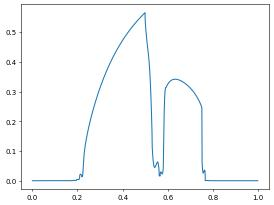

In [28]:
x0 = FieldVector([0.25,  0.65])
x1 = FieldVector([0.775, 0.39])
p,v = algorithm.run('sample', 'utility.hh', solution, x0, x1, 1000)

x = numpy.zeros(len(p))
y = numpy.zeros(len(p))
l = (x1-x0).two_norm
for i in range(len(x)):
    x[i] = (p[i]-x0).two_norm / l
    y[i] = v[i][1]
pyplot.plot(x,y)

In [29]:
from dune.fem.function import levelFunction
@gridFunction(gridView=grid,name="polOrder",order=0)
def polOrder(e,x):
    return [spc.localOrder(e)]
plot(solution[0],figsize=(15,4))
plot(solution[1],figsize=(15,4))
plot(polOrder,figsize=(15,4))
plot(levelFunction(grid),figsize=(15,4))